In [1]:
#https://github.com/cdt15/lingam/blob/master/lingam/var_lingam.py

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
pip install lingam graphviz statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.4/134.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 6.6 MB/s eta 0:00:00
  Created wheel for semopy: filename=semopy-2.3.11-py3-none-any.whl size=1659682 sha256=7acbb0dd16c57ecf34f55c0b818eaf9a47eb181f47f898d3397140b7c470c21d
  Stored in directory: /root/.cache/pip/wheels/c6/24/8b/be911b059a61f490f38425eb19bf2fed470a5ead97228e8255
Successfully built semopy


In [4]:
"""
Python implementation of the LiNGAM algorithms.
The LiNGAM Project: https://sites.google.com/view/sshimizu06/lingam
"""
import itertools
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.utils import check_array, resample
from statsmodels.tsa.vector_ar.var_model import VAR

# Corrected imports
from lingam.base import _BaseLiNGAM
from lingam.bootstrap import BootstrapResult
from lingam.direct_lingam import DirectLiNGAM
from lingam.hsic import hsic_test_gamma
from lingam.utils import predict_adaptive_lasso, find_all_paths, calculate_total_effect


class VARLiNGAM:
    """Implementation of VAR-LiNGAM Algorithm [1]_

    References
    ----------
    .. [1] Aapo Hyvärinen, Kun Zhang, Shohei Shimizu, Patrik O. Hoyer.
       Estimation of a Structural Vector Autoregression Model Using Non-Gaussianity.
       Journal of Machine Learning Research, 11: 1709-1731, 2010.
    """

    def __init__(
        self,
        lags=1,
        criterion="bic",
        prune=True,
        ar_coefs=None,
        lingam_model=None,
        random_state=None,
    ):
        """Construct a VARLiNGAM model.

        Parameters
        ----------
        lags : int, optional (default=1)
            Number of lags.
        criterion : {‘aic’, ‘fpe’, ‘hqic’, ‘bic’, None}, optional (default='bic')
            Criterion to decide the best lags within ``lags``.
            Searching the best lags is disabled if ``criterion`` is ``None``.
        prune : boolean, optional (default=True)
            Whether to prune the adjacency matrix of lags.
        ar_coefs : array-like, optional (default=None)
            Coefficients of AR model. Estimating AR model is skipped if specified ``ar_coefs``.
            Shape must be (``lags``, n_features, n_features).
        lingam_model : lingam object inherits 'lingam._BaseLiNGAM', optional (default=None)
            LiNGAM model for causal discovery. If None, DirectLiNGAM algorithm is selected.
        random_state : int, optional (default=None)
            ``random_state`` is the seed used by the random number generator.
        """
        self._lags = lags
        self._criterion = criterion
        self._prune = prune
        self._ar_coefs = (
            check_array(ar_coefs, allow_nd=True) if ar_coefs is not None else None
        )
        self._lingam_model = lingam_model
        self._random_state = random_state

    def fit(self, X):
        """Fit the model to X.

        Parameters
        ----------
        X: array-like, shape (n_samples, n_features)
            Training data, where ``n_samples`` is the number of samples
            and ``n_features`` is the number of features.

        returns
        -------
        self : object
            Returns the instance itself.
        """
        self._causal_order = None
        self._adjacency_matrices = None

        X = check_array(X)

        lingam_model = self._lingam_model
        if lingam_model is None:
            lingam_model = DirectLiNGAM()
        elif not isinstance(lingam_model, _BaseLiNGAM):
            raise ValueError("lingam_model must be a subclass of _BaseLiNGAM")

        M_taus = self._ar_coefs

        if M_taus is None:
            M_taus, lags, residuals = self._estimate_var_coefs(X)
        else:
            lags = M_taus.shape[0]
            residuals = self._calc_residuals(X, M_taus, lags)

        self._ar_coefs = M_taus
        self._lags = lags
        self._residuals = residuals

        model = lingam_model
        model.fit(residuals)

        B_taus = self._calc_b(X, model.adjacency_matrix_, M_taus)

        if self._prune:
            B_taus = self._pruning(X, B_taus, model.causal_order_)

        self._causal_order = model.causal_order_
        self._adjacency_matrices = B_taus

        return self

    def bootstrap(self, X, n_sampling):
        """Evaluate the statistical reliability of DAG based on the bootstrapping.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where ``n_samples`` is the number of samples
            and ``n_features`` is the number of features.
        n_sampling : int
            Number of bootstrapping samples.

        Returns
        -------
        result : TimeseriesBootstrapResult
            Returns the result of bootstrapping.
        """
        X = check_array(X)

        n_samples = X.shape[0]
        n_features = X.shape[1]

        # store initial settings
        ar_coefs = self._ar_coefs
        lags = self._lags

        criterion = self._criterion
        self._criterion = None

        self.fit(X)

        fitted_ar_coefs = self._ar_coefs
        residuals = self._residuals

        total_effects = np.zeros(
            [n_sampling, n_features, n_features * (1 + self._lags)]
        )

        adjacency_matrices = []
        for i in range(n_sampling):
            sampled_residuals = resample(residuals, n_samples=n_samples)

            resampled_X = np.zeros((n_samples, n_features))
            for j in range(n_samples):
                if j < lags:
                    resampled_X[j, :] = sampled_residuals[j]
                    continue

                ar = np.zeros((1, n_features))
                for t, M in enumerate(fitted_ar_coefs):
                    ar += np.dot(M, resampled_X[j - t - 1, :].T).T

                resampled_X[j, :] = ar + sampled_residuals[j]

            # restore initial settings
            self._ar_coefs = ar_coefs
            self._lags = lags

            self.fit(resampled_X)
            am = np.concatenate([*self._adjacency_matrices], axis=1)
            adjacency_matrices.append(am)

            # total effects
            for c, to in enumerate(reversed(self._causal_order)):
                # time t
                for from_ in self._causal_order[: n_features - (c + 1)]:
                    total_effects[i, to, from_] = self.estimate_total_effect2(
                        n_features, from_, to
                    )

                # time t-tau
                for lag in range(self._lags):
                    for from_ in range(n_features):
                        total_effects[
                            i, to, from_ + n_features * (lag + 1)
                        ] = self.estimate_total_effect2(n_features, from_, to, lag + 1)

        self._criterion = criterion

        return VARBootstrapResult(adjacency_matrices, total_effects)

    def estimate_total_effect(self, X, from_index, to_index, from_lag=0):
        """Estimate total effect using causal model.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Original data, where n_samples is the number of samples
            and n_features is the number of features.
        from_index :
            Index of source variable to estimate total effect.
        to_index :
            Index of destination variable to estimate total effect.

        Returns
        -------
        total_effect : float
            Estimated total effect.
        """
        X = check_array(X)
        n_features = X.shape[1]

        # Check from/to causal order
        if from_lag == 0:
            from_order = self._causal_order.index(from_index)
            to_order = self._causal_order.index(to_index)
            if from_order > to_order:
                warnings.warn(
                    f"The estimated causal effect may be incorrect because "
                    f"the causal order of the destination variable (to_index={to_index}) "
                    f"is earlier than the source variable (from_index={from_index})."
                )

        # X + lagged X
        X_joined = np.zeros((X.shape[0], X.shape[1] * (1 + self._lags + from_lag)))
        for p in range(1 + self._lags + from_lag):
            pos = n_features * p
            X_joined[:, pos : pos + n_features] = np.roll(X[:, 0:n_features], p, axis=0)

        # from_index + parents indices
        am = np.concatenate([*self._adjacency_matrices], axis=1)
        parents = np.where(np.abs(am[from_index]) > 0)[0]
        from_index = (
            from_index if from_lag == 0 else from_index + (n_features * from_lag)
        )
        parents = parents if from_lag == 0 else parents + (n_features * from_lag)
        predictors = [from_index]
        predictors.extend(parents)

        # estimate total effect
        lr = LinearRegression()
        lr.fit(X_joined[:, predictors], X_joined[:, to_index])

        return lr.coef_[0]

    def estimate_total_effect2(self, n_features, from_index, to_index, from_lag=0):
        """Estimate total effect using causal model.

        Parameters
        ----------
        n_features :
            The number of features.
        from_index :
            Index of source variable to estimate total effect.
        to_index :
            Index of destination variable to estimate total effect.

        Returns
        -------
        total_effect : float
            Estimated total effect.
        """
        # Check from/to causal order
        if from_lag == 0:
            from_order = self._causal_order.index(from_index)
            to_order = self._causal_order.index(to_index)
            if from_order > to_order:
                warnings.warn(
                    f"The estimated causal effect may be incorrect because "
                    f"the causal order of the destination variable (to_index={to_index}) "
                    f"is earlier than the source variable (from_index={from_index})."
                )

        # from_index + parents indices
        am = np.concatenate([*self._adjacency_matrices], axis=1)
        am = np.pad(am, [(0, am.shape[1] - am.shape[0]), (0, 0)])
        from_index = (
            from_index if from_lag == 0 else from_index + (n_features * from_lag)
        )

        effect = calculate_total_effect(am, from_index, to_index)

        return effect

    def get_error_independence_p_values(self):
        """Calculate the p-value matrix of independence between error variables.

        Returns
        -------
        independence_p_values : array-like, shape (n_features, n_features)
            p-value matrix of independence between error variables.
        """
        nn = self.residuals_
        B0 = self._adjacency_matrices[0]
        E = np.dot(np.eye(B0.shape[0]) - B0, nn.T).T
        n_samples = E.shape[0]
        n_features = E.shape[1]

        p_values = np.zeros([n_features, n_features])
        for i, j in itertools.combinations(range(n_features), 2):
            _, p_value = hsic_test_gamma(
                np.reshape(E[:, i], [n_samples, 1]), np.reshape(E[:, j], [n_samples, 1])
            )
            p_values[i, j] = p_value
            p_values[j, i] = p_value

        return p_values

    def _estimate_var_coefs(self, X):
        """Estimate coefficients of VAR"""
        # XXX: VAR.fit() is not searching lags correctly
        if self._criterion not in ["aic", "fpe", "hqic", "bic"]:
            var = VAR(X)
            result = var.fit(maxlags=self._lags, trend="n")
        else:
            min_value = float("Inf")
            result = None

            for lag in range(1, self._lags + 1):
                var = VAR(X)
                fitted = var.fit(maxlags=lag, ic=None, trend="n")

                value = getattr(fitted, self._criterion)
                if value < min_value:
                    min_value = value
                    result = fitted

        return result.coefs, result.k_ar, result.resid

    def _calc_residuals(self, X, M_taus, lags):
        """Calculate residulas"""
        X = X.T
        n_features = X.shape[0]
        n_samples = X.shape[1]

        residuals = np.zeros((n_features, n_samples))
        for t in range(n_samples):
            if t - lags < 0:
                continue

            estimated = np.zeros((X.shape[0], 1))
            for tau in range(1, lags + 1):
                estimated += np.dot(M_taus[tau - 1], X[:, t - tau].reshape((-1, 1)))

            residuals[:, t] = X[:, t] - estimated.reshape((-1,))

        residuals = residuals[:, lags:].T

        return residuals

    def _calc_b(self, X, B0, M_taus):
        """Calculate B"""
        n_features = X.shape[1]

        B_taus = np.array([B0])

        for M in M_taus:
            B_t = np.dot((np.eye(n_features) - B0), M)
            B_taus = np.append(B_taus, [B_t], axis=0)

        return B_taus

    def _pruning(self, X, B_taus, causal_order):
        """Prune edges"""
        n_features = X.shape[1]

        stacked = [np.flip(X, axis=0)]
        for i in range(self._lags):
            stacked.append(np.roll(stacked[-1], -1, axis=0))
        blocks = np.array(list(zip(*stacked)))[: -self._lags]

        for i in range(n_features):
            causal_order_no = causal_order.index(i)
            ancestor_indexes = causal_order[:causal_order_no]

            obj = np.zeros((len(blocks)))
            exp = np.zeros((len(blocks), causal_order_no + n_features * self._lags))
            for j, block in enumerate(blocks):
                obj[j] = block[0][i]
                exp[j:] = np.concatenate(
                    [block[0][ancestor_indexes].flatten(), block[1:][:].flatten()],
                    axis=0,
                )

            # adaptive lasso
            predictors = [i for i in range(exp.shape[1])]
            target = len(predictors)
            X_con = np.concatenate([exp, obj.reshape(-1, 1)], axis=1)
            coef = predict_adaptive_lasso(X_con, predictors, target)

            B_taus[0][i, ancestor_indexes] = coef[:causal_order_no]
            for j in range(len(B_taus[1:])):
                B_taus[j + 1][i, :] = coef[
                    causal_order_no + n_features * j :
                    causal_order_no + n_features * j + n_features
                ]

        return B_taus

    @property
    def causal_order_(self):
        """Estimated causal ordering.

        Returns
        -------
        causal_order_ : array-like, shape (n_features)
            The causal order of fitted model, where
            n_features is the number of features.
        """
        return self._causal_order

    @property
    def adjacency_matrices_(self):
        """Estimated adjacency matrix.

        Returns
        -------
        adjacency_matrices_ : array-like, shape (lags, n_features, n_features)
            The adjacency matrix of fitted model, where
            n_features is the number of features.
        """
        return self._adjacency_matrices

    @property
    def residuals_(self):
        """Residuals of regression.

        Returns
        -------
        residuals_ : array-like, shape (n_samples)
            Residuals of regression, where n_samples is the number of samples.
        """
        return self._residuals

In [5]:
def predict_adaptive_lasso(X, predictors, target, gamma=1.0):
    """Predict with Adaptive Lasso.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Training data, where n_samples is the number of samples
        and n_features is the number of features.
    predictors : array-like, shape (n_predictors)
        Indices of predictor variable.
    target : int
        Index of target variable.

    Returns
    -------
    coef : array-like, shape (n_features)
        Coefficients of predictor variable.
    """
    # Standardize X
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    # Pruning with Adaptive Lasso
    lr = LinearRegression()
    lr.fit(X_std[:, predictors], X_std[:, target])
    weight = np.power(np.abs(lr.coef_), gamma)
    reg = LassoLarsIC(criterion="bic")
    reg.fit(X_std[:, predictors] * weight, X_std[:, target])
    pruned_idx = np.abs(reg.coef_ * weight) > 0.0

    # Calculate coefficients of the original scale
    coef = np.zeros(reg.coef_.shape)
    if pruned_idx.sum() > 0:
        lr = LinearRegression()
        pred = np.array(predictors)
        lr.fit(X[:, pred[pruned_idx]], X[:, target])
        coef[pruned_idx] = lr.coef_

    return coef

# VAR-LiNGAM con BALLOON

## Intento 1

In [16]:
# ==========================================
# VAR-LiNGAM factual
# ==========================================
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from lingam import VARLiNGAM

# --- Semillas (reproducibilidad) ---
np.random.seed(42)
random.seed(42)

# --- Rutas ---
base_path = "/content/drive/MyDrive/Balloon"

# --- Cargar señales BOLD ---
bold_clean = np.load(f"{base_path}/bold_clean.npy")   # opcional (sin ruido)
bold_noisy = np.load(f"{base_path}/bold_noisy.npy")   # principal (con ruido)

# --- Seleccionar datos ---
#X = bold_noisy                     #############################################
X = bold_clean  # (T x D)

from sklearn.preprocessing import StandardScaler

# X: matriz T x D (filas=tiempo, columnas=ROIs)
scaler = StandardScaler()
Xz = scaler.fit_transform(X)   # z-score por ROI

#model = VARLiNGAM(lags=1, prune=True)
model = VARLiNGAM(lags=8, criterion='bic', prune=True)
model.fit(Xz)
B = model.adjacency_matrices_  # [B0, B1, ...]

#order = model.causal_order_

# --- Mostrar resultados básicos ---
print("B0 shape:", B[0].shape)
print("Número de lags estimados:", len(B)-1)

# --- (Opcional) matriz efectiva (suma de los lags > 0) ---
# Include the instantaneous effects (B0) in the effective matrix
B_effective = sum(B)

# --- Guardar resultados ---
np.save(f"{base_path}/B0_factual.npy", B[0])
np.save(f"{base_path}/B_effective_factual.npy", B_effective)

print("Matrices guardadas en:", base_path)

B0 shape: (10, 10)
Número de lags estimados: 4
Matrices guardadas en: /content/drive/MyDrive/Balloon


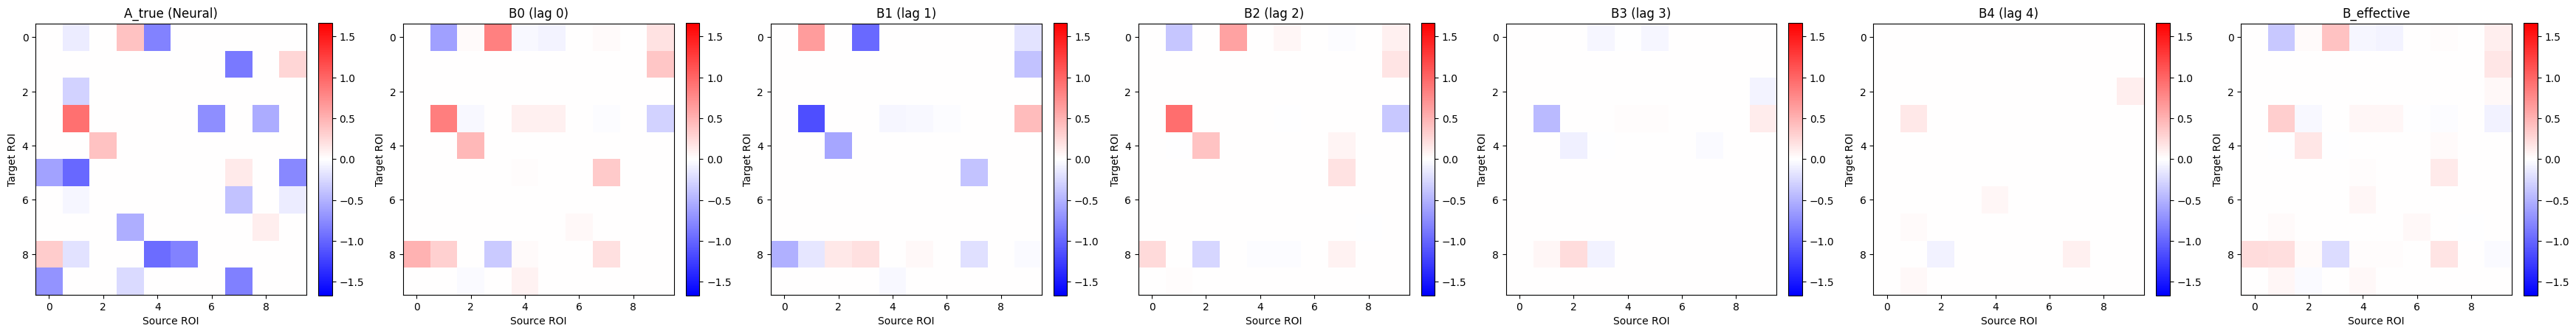

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# --- Cargar matriz de adyacencia neuronal verdadera ---
A_true = np.load(f"{base_path}/A_true.npy")

# --- Visualizar cada lag ---
n_lags = len(B)
# Add A_true to the list of matrices to plot
# You might want to add error handling if A_true is not defined
if 'A_true' in locals() and A_true is not None:
    mats_to_plot = [(f"B{i} (lag {i})", B[i]) for i in range(n_lags)]
    mats_to_plot.insert(0, ("A_true (Neural)", A_true)) # Add A_true at the beginning
else:
    mats_to_plot = [(f"B{i} (lag {i})", B[i]) for i in range(n_lags)]

# Add B_effective to the list of matrices to plot
if 'B_effective' in locals() and B_effective is not None:
    mats_to_plot.append(("B_effective", B_effective))

n_mats = len(mats_to_plot) # Update the number of matrices
fig, axes = plt.subplots(1, n_mats, figsize=(5 * n_mats, 5))

if n_mats == 1: # Handle the case of a single subplot
    axes = [axes]

# Determine global color scale
v = max(np.max(np.abs(M)) for _, M in mats_to_plot)
v = 1.0 if v == 0 else v

for i, (title, M) in enumerate(mats_to_plot):
    ax = axes[i]
    # Set the diagonal to zero
    M_no_diag = M.copy()
    np.fill_diagonal(M_no_diag, 0)

    im = ax.imshow(M_no_diag, cmap='bwr',
                   vmin=-v, # Use global vmin
                   vmax=v)   # Use global vmax
    ax.set_title(title)
    ax.set_xlabel("Source ROI")
    ax.set_ylabel("Target ROI")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

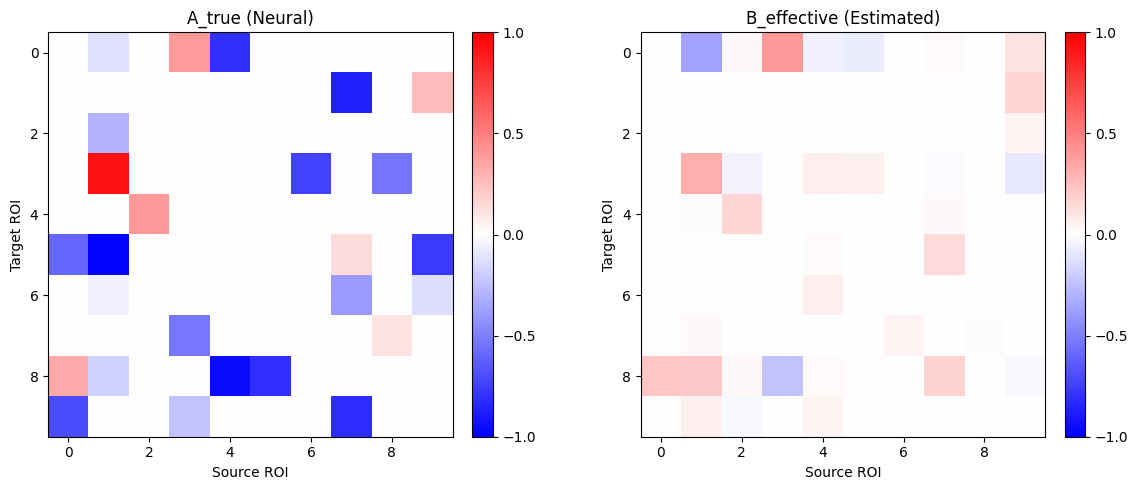

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# --- Cargar matrices ---
base_path = "/content/drive/MyDrive/Balloon"
A_true = np.load(f"{base_path}/A_true.npy")
B_effective = np.load(f"{base_path}/B_effective_factual.npy")

# --- Visualizar A_true y B_effective ---
mats_to_plot = [
    ("A_true (Neural)", A_true),
    ("B_effective (Estimated)", B_effective)
]

n_mats = len(mats_to_plot)
fig, axes = plt.subplots(1, n_mats, figsize=(6 * n_mats, 5))

if n_mats == 1:
    axes = [axes]

# Determine global color scale (setting it to -1 to 1 for requested ticks)
v_min_fixed = -1.0
v_max_fixed = 1.0

for i, (title, M) in enumerate(mats_to_plot):
    ax = axes[i]
    # Set the diagonal to zero for better visualization of connections
    M_no_diag = M.copy()
    np.fill_diagonal(M_no_diag, 0)

    im = ax.imshow(M_no_diag, cmap='bwr',
                   vmin=v_min_fixed,
                   vmax=v_max_fixed)
    ax.set_title(title)
    ax.set_xlabel("Source ROI")
    ax.set_ylabel("Target ROI")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, ticks=[-1, -0.5, 0, 0.5, 1])

plt.tight_layout()
plt.show()

Optimal Threshold (by F1-score): 0.1193


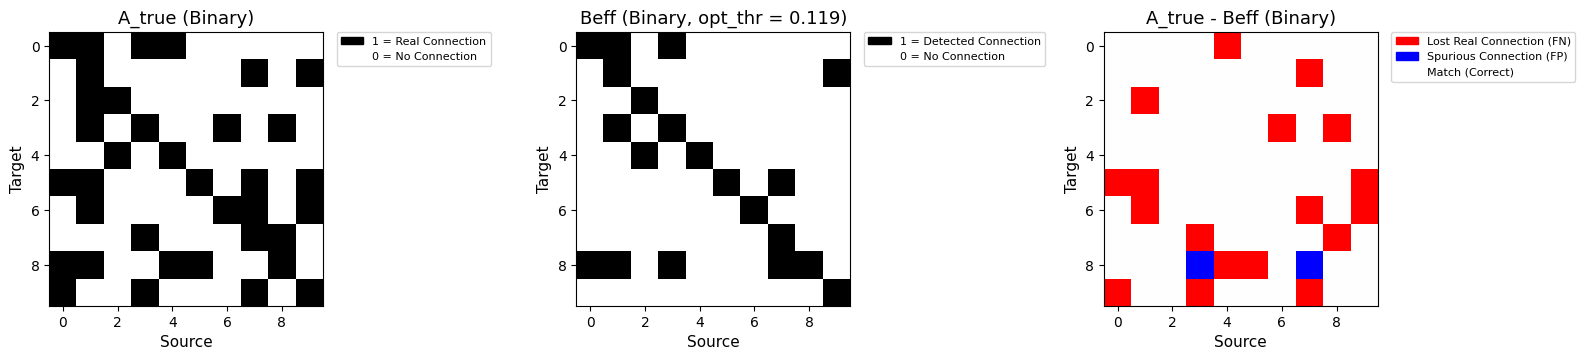

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import f1_score

# ---------------------------------------------------
# Cargar matrices
# ---------------------------------------------------
base_path = "/content/drive/MyDrive/Balloon"
A = np.load(f"{base_path}/A_true.npy")
Beff = np.load(f"{base_path}/B_effective_factual.npy")
assert A.shape == Beff.shape, "Matrices must have the same size"

# ---------------------------------------------------
# Convertir A_true a binaria
# ---------------------------------------------------
A_bin = (np.abs(A) > 0).astype(int)
truth = A_bin.flatten()

# ---------------------------------------------------
# Calcular umbral óptimo (max F1)
# ---------------------------------------------------
vals = np.abs(Beff.flatten())
thr_grid = np.linspace(np.percentile(vals, 5), np.percentile(vals, 95), 100)
f1_scores = []

for thr in thr_grid:
    pred = (vals >= thr).astype(int)
    f1_scores.append(f1_score(truth, pred))

thr_opt = thr_grid[np.argmax(f1_scores)]
print(f"Optimal Threshold (by F1-score): {thr_opt:.4f}")

# Binarizar Beff con thr óptimo
B_bin = (np.abs(Beff) >= thr_opt).astype(int)

# ---------------------------------------------------
# Diferencia estructural
# ---------------------------------------------------
diff_bin = A_bin - B_bin  # 1 = lost (FN), -1 = spurious (FP), 0 = correct

# ---------------------------------------------------
# Figura con tres paneles más grandes
# ---------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(16, 5))  # <-- larger figure

# ---------- Panel 1: A_true ----------
im0 = axes[0].imshow(A_bin, cmap="Greys", interpolation="nearest")
axes[0].set_title("A_true (Binary)", fontsize=13)
axes[0].set_xlabel("Source", fontsize=11)
axes[0].set_ylabel("Target", fontsize=11)
axes[0].legend(
    handles=[
        mpatches.Patch(color='black', label='1 = Real Connection'),
        mpatches.Patch(color='white', label='0 = No Connection')],
    bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
    fontsize=8  # <-- smaller text
)

# ---------- Panel 2: Beff binaria ----------
im1 = axes[1].imshow(B_bin, cmap="Greys", interpolation="nearest")
axes[1].set_title(f"Beff (Binary, opt_thr = {thr_opt:.3f})", fontsize=13)
axes[1].set_xlabel("Source", fontsize=11)
axes[1].set_ylabel("Target", fontsize=11)
axes[1].legend(
    handles=[
        mpatches.Patch(color='black', label='1 = Detected Connection'),
        mpatches.Patch(color='white', label='0 = No Connection')],
    bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
    fontsize=8
)

# ---------- Panel 3: A - Beff ----------
im2 = axes[2].imshow(diff_bin, cmap="bwr", interpolation="nearest", vmin=-1, vmax=1)
axes[2].set_title("A_true - Beff (Binary)", fontsize=13)
axes[2].set_xlabel("Source", fontsize=11)
axes[2].set_ylabel("Target", fontsize=11)
axes[2].legend(
    handles=[
        mpatches.Patch(color='red', label='Lost Real Connection (FN)'),
        mpatches.Patch(color='blue', label='Spurious Connection (FP)'),
        mpatches.Patch(color='white', label='Match (Correct)')],
    bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
    fontsize=8
)

plt.tight_layout()
plt.show()

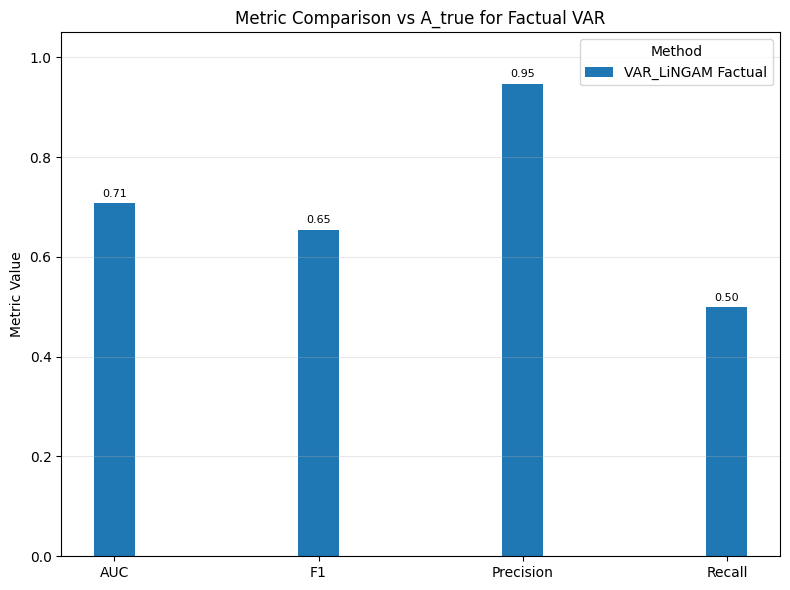

In [14]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

def calculate_all_metrics(A_true_matrix, B_estimated_matrix):
    # Flatten and binarize A_true_matrix
    A_bin = (np.abs(A_true_matrix) > 0).astype(int)
    truth = A_bin.flatten()

    # Use absolute values for B_estimated_matrix for thresholding
    abs_Beff = np.abs(B_estimated_matrix)

    # Calculate optimal threshold based on F1-score (as done in previous cells)
    vals = abs_Beff.flatten()
    # Handle cases where vals might be all zeros or contain NaNs
    if np.all(vals == 0) or np.isnan(vals).all():
        thr_opt = 0.0
    else:
        # Exclude NaNs from percentile calculation if any
        valid_vals = vals[~np.isnan(vals)]
        if len(valid_vals) == 0:
            thr_opt = 0.0
        else:
            # Ensure percentile range is valid; if min == max, then linspace would fail or be trivial
            p5 = np.percentile(valid_vals, 5)
            p95 = np.percentile(valid_vals, 95)
            if p5 == p95:
                thr_grid = np.array([p5]) if p5 > 0 else np.array([0.001]) # Use a small non-zero threshold if all values are identical and zero
            else:
                thr_grid = np.linspace(p5, p95, 100)

            f1_scores_thr = []
            for thr in thr_grid:
                pred_at_thr = (vals >= thr).astype(int)
                f1_scores_thr.append(f1_score(truth, pred_at_thr, zero_division=0))

            if len(f1_scores_thr) == 0 or np.max(f1_scores_thr) == 0:
                thr_opt = 0.0 # Handle cases where no F1 score can be found
            else:
                thr_opt = thr_grid[np.argmax(f1_scores_thr)]

    # Binarize Beff with optimal threshold
    B_bin_optimal = (abs_Beff >= thr_opt).astype(int)
    pred_optimal = B_bin_optimal.flatten()

    # Calculate F1, Precision, Recall at optimal threshold
    f1 = f1_score(truth, pred_optimal, zero_division=0)
    precision = precision_score(truth, pred_optimal, zero_division=0)
    recall = recall_score(truth, pred_optimal, zero_division=0)

    # For AUC, we use the continuous values of abs_Beff
    # Ensure there are both positive and negative classes in truth
    if len(np.unique(truth)) < 2 or np.all(np.isnan(vals)) or len(np.unique(vals)) < 2:
        # If truth contains only one class, AUC is not well-defined
        # Or if prediction scores are all NaN or only one unique value, AUC is not well-defined.
        roc_auc = np.nan # Assign NaN if AUC cannot be computed meaningfully
    else:
        fpr, tpr, _ = roc_curve(truth, vals)
        roc_auc = auc(fpr, tpr)

    return {"AUC": roc_auc, "F1": f1, "Prec": precision, "Rec": recall}

# Use this function with the existing A_true and Beff
metrics_var_factual = calculate_all_metrics(A_true, Beff)

auc_vals = [metrics_var_factual["AUC"]]
f1_vals = [metrics_var_factual["F1"]]
prec_vals = [metrics_var_factual["Prec"]]
rec_vals = [metrics_var_factual["Rec"]]

orden = ["VAR_LiNGAM Factual"] # Only one method for now

metrics_labels = ["AUC", "F1", "Precision", "Recall"]
metric_values = [auc_vals, f1_vals, prec_vals, rec_vals]

x = np.arange(len(metrics_labels))
width = 0.2 # Adjusted width for a single bar group

fig, ax = plt.subplots(figsize=(8, 6)) # Adjusted figsize

for i, method_name in enumerate(orden):
    vals_for_method = [metric_values[j][i] for j in range(len(metrics_labels))]
    ax.bar(x + i * width, vals_for_method, width, label=method_name)

ax.set_xticks(x + (len(orden) - 1) * width / 2)
ax.set_xticklabels(metrics_labels)
ax.set_ylabel("Metric Value")
ax.set_ylim(0, 1.05)
ax.set_title("Metric Comparison vs A_true for Factual VAR")
ax.legend(title="Method", loc='upper right')
ax.grid(True, axis="y", alpha=0.3)

# Labels on top of each bar
for container in ax.containers:
    for rect in container:
        height = rect.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()